## Initial imports

In [1]:
import scm.plams as plams
from scm.params import ResultsImporter, ParAMSJob
from scm.plams import Settings, AMSJob, log, Molecule, packmol_on_slab
from pathlib import Path
import matplotlib.pyplot as plt

# common_ru_h.py must exist in the current working directory
from common_ru_h import rotation, check_installation

## Initialize PLAMS working directory

In [2]:
old_ref_dir = "reference_data_3"
check_installation(old_ref_dir)
new_ref_dir = "reference_data_4"
plams.init()

Current AMS version: 2024.102
05-31 15:46:43 m3gnet is installed: M3GNet ML Backend v[0.2.4] - build:0 [06668e0a45ce742d8f66ff23484b8a1e]
05-31 15:46:43 qe is installed: Quantum ESPRESSO (AMSPIPE) v[7.1] - build:115 [777d72eb480fe4d632a003cc62e9c1cb]
PLAMS working folder: /home/hellstrom/SALRuH/fix2024/plams_workdir.004


## Perform training/validation split

In [3]:
## Create a training/validation split
ri = ResultsImporter.from_yaml(old_ref_dir)
log("Performing training/validation split")
training_set, validation_set = ri.get_data_set("training_set").split_by_jobids(
    0.95, 0.05, seed=314
)
ri.data_sets = {"training_set": training_set, "validation_set": validation_set}
log(
    f"{len(training_set)} training set entries; {len(validation_set)} validation set entries."
)
log(f"Storing in {new_ref_dir}")
ri.store(new_ref_dir);

[31.05|15:46:45] Performing training/validation split
[31.05|15:46:45] 126 training set entries; 8 validation set entries.
[31.05|15:46:45] Storing in reference_data_4


## Create a ParAMS Job for transfer learning on the M3GNet universal potential

In [4]:
job = ParAMSJob.from_yaml(new_ref_dir)
job.name = "initial_training"
inp = job.settings.input
inp.Task = "MachineLearning"
inp.MachineLearning.CommitteeSize = 1  # train only a single model
inp.MachineLearning.MaxEpochs = 250
inp.MachineLearning.LossCoeffs.Energy = 10.0
inp.MachineLearning.LossCoeffs.Forces = 1.0
inp.MachineLearning.Backend = "M3GNet"
inp.MachineLearning.M3GNet.LearningRate = 1e-3
inp.MachineLearning.M3GNet.Model = "UniversalPotential"
inp.MachineLearning.M3GNet.UniversalPotential = Settings(
    Featurizer="No",  # must use strings here, not Python booleans
    ThreeDInteractions1="No",
    GraphLayer1="No",
    ThreeDInteractions2="No",
    GraphLayer2="No",
    ThreeDInteractions3="Yes",
    GraphLayer3="Yes",
    Final="Yes",
)
inp.MachineLearning.Target.Forces.Enabled = "Yes"
inp.MachineLearning.Target.Forces.MAE = 0.05
inp.MachineLearning.RunAMSAtEnd = "Yes"
# Larger batch sizes require more (GPU) memory but will also typically train faster
# The amount of memory also depends on the number of atoms in the structures
# So set the batch size to some appropriate number
inp.DataSet[0].BatchSize = 10  # training set batch size
inp.DataSet[1].BatchSize = 10  # validation set batch size
print(job.get_input())

Task MachineLearning

DataSet
  BatchSize 10
  Name training_set
  Path /home/hellstrom/SALRuH/fix2024/reference_data_4/training_set.yaml
end
DataSet
  BatchSize 10
  Name validation_set
  Path /home/hellstrom/SALRuH/fix2024/reference_data_4/validation_set.yaml
end

JobCollection /home/hellstrom/SALRuH/fix2024/reference_data_4/job_collection.yaml

EngineCollection /home/hellstrom/SALRuH/fix2024/reference_data_4/job_collection_engines.yaml

MachineLearning
  Backend M3GNet
  CommitteeSize 1
  LossCoeffs
    Energy 10.0
    Forces 1.0
  End
  M3GNet
    LearningRate 0.001
    Model UniversalPotential
    UniversalPotential
      Featurizer No
      Final Yes
      GraphLayer1 No
      GraphLayer2 No
      GraphLayer3 Yes
      ThreeDInteractions1 No
      ThreeDInteractions2 No
      ThreeDInteractions3 Yes
    End
  End
  MaxEpochs 250
  RunAMSAtEnd Yes
  Target
    Forces
      Enabled Yes
      MAE 0.05
    End
  End
end




In [5]:
job.run();

[31.05|15:46:45] JOB initial_training STARTED
[31.05|15:46:45] JOB initial_training RUNNING
[31.05|15:56:49] JOB initial_training FINISHED
[31.05|15:56:49] JOB initial_training SUCCESSFUL


## Plot some results of the training

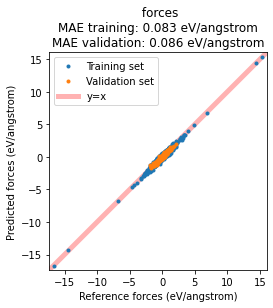

In [6]:
job.results.plot_simple_correlation("forces");

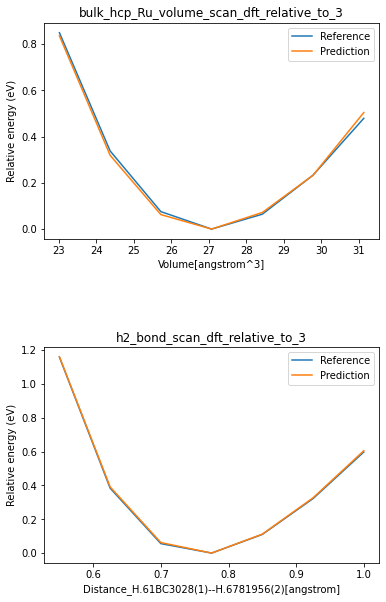

In [7]:
job.results.plot_all_pes()
plt.subplots_adjust(top=2, hspace=0.5);

## Copy the results directory to a known place

In [8]:
import shutil

orig_training_results_dir = str(job.results.path)
new_training_results_dir = Path("initial_training_results").resolve()
log(f"Copying {orig_training_results_dir} to {new_training_results_dir}")
shutil.copytree(orig_training_results_dir, new_training_results_dir, dirs_exist_ok=True)
log(f"Use {new_training_results_dir} as the LoadModel in upcoming active learning.")

[31.05|15:56:50] Copying /home/hellstrom/SALRuH/fix2024/plams_workdir.004/initial_training/results to /home/hellstrom/SALRuH/fix2024/initial_training_results
[31.05|15:56:50] Use /home/hellstrom/SALRuH/fix2024/initial_training_results as the LoadModel in upcoming active learning.
